<center><h1>BERT Архитектура</h1></center>

<p >Существует четыре типа предварительно обученных версий BERT в зависимости от масштаба архитектуры модели:</p>
<ol>
    <li>BERT-Base (Cased / Un-Cased): 12-layer, 768-hidden-nodes, 12-attention-heads, 110M parameters</li>
    <li>BERT-Large (Cased / Un-Cased): 24-layer, 1024-hidden-nodes, 16-attention-heads, 340M parameters</li>
</ol>

<p>Нам нужно выбрать, <b>какие предварительно обученные веса BERT нам нужны</b>. Например, если у нас нет доступа к большим вычислительным ресурсам, мы предпочитаем использовать базовые модели. И тогда выбор cased «с регистром» или uncased «без регистра» зависит от того, считаем ли мы, что регистр букв будет полезен для поставленной задачи.</p>

<center><h1>Предисловие</h1></center>

<br><center><h1>1. <u>Предобработка текста</u></h1></center>
<br>
<p>BERT опирается на Трансформатор (механизм внимания, который изучает контекстуальные связи между словами в тексте). Базовый преобразователь состоит из енкодера для чтения текстового ввода и декодера для прогнозирования задачи. Поскольку целью BERT является создание модели языкового представления, ему нужна только часть енкодера. Входными данными для кодировщика BERT является последовательность токенов, которые сначала преобразуются в векторы, а затем обрабатываются в нейронной сети. Начнем с того, что каждый входной эмбеддинг представляет собой комбинацию трех эмбеддингов:</p>


<br><center><h1>Входное представление для BERT: входные эмбеддинги представляют собой сумму эмбеддингов токенов, эмбеддингов сегментации и позиции.</h1></center>
<br>
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<ul>
    <li><b>Эмбеддинги токенов:</b> токен [CLS] добавляется к токенам входного слова в начале первого предложения, а токен [SEP] вставляется в конце каждого предложения.</li >
     <li><b>Эмбеддинги сегментов.</b>К каждому токену добавляется маркер, обозначающий предложение A или предложение B. Это позволяет кодировщику различать предложения.</li>
     <li><b>Позиционные эмбеддинги.</b> К каждому токену добавляется позиционные эмбеддинги, чтобы указать его положение в предложении.</li>
</ul>
<br><center><h1>2. <u>Предобучение</u></h1></center>
<br>
<p>BERT предварительно обучен решению двух задач НЛП:</p>

<h1> 1. Моделирование языка в масках</h1>
<ul>
     <li>Моделирование языка — это задача прогнозирования следующего слова по последовательности слов. При моделировании языка масок вместо прогнозирования каждого следующего токена процент входных токенов маскируется случайным образом, и прогнозируются только эти замаскированные токены.</li>
     <li> [MASK] Токен — это токен, обозначающий отсутствие токена.</li>
     <li> Замаскированные слова не всегда заменяются замаскированным токеном – [MASK], потому что тогда замаскированные токены никогда не будут видны до точной настройки. Поэтому 15% токенов выбираются случайным образом. А из 15% токенов, выбранных для маскировки:</li>
     <br>
     <center><h1>80% токенов фактически заменяются токеном [MASK].</h1></center>
     <center><h1>10% токенов заменяются случайными токенами.</h1></center>
     <center><h1>10 % токенов времени остаются неизменными.</h1></center>
</ul>
<br>
<h1> 2. Прогнозирование следующего предложения</h1>
<ul>
     <li>Задача прогнозирования следующего предложения — это задача двоичной классификации, в которой по паре предложений прогнозируется, является ли второе предложение фактически следующим предложением первого предложения.</li>
     <br>
     <center><img src="https://yashuseth.files.wordpress.com/2019/06/fig5.png?w=442&h=231"></center>
     <br>
     <li>Эту задачу можно легко сгенерировать на основе любого одноязычного корпуса. Это полезно, поскольку многие последующие задачи, такие как вопросы и ответы и вывод на естественном языке, требуют понимания взаимосвязи между двумя предложениями.</li>
</ul>

<center><h1>Модель обучается одновременно с помощью Masked LM и прогнозирования следующего предложения. Это делается для того, чтобы минимизировать совокупную функцию потерь двух стратегий.</h1></center>


<br>
<center><h1>Примение модели BERT</h1></center>

<p><b>Постановка задачи:</b> У нас есть коллекция SMS-сообщений. Некоторые из этих сообщений являются спамом, а остальные подлинными. Наша задача — построить систему, которая бы автоматически определяла, является ли сообщение спамом или нет.</p>

<h1>1. Импорт библиотек и загрузка набора данных</h1>

In [ ]:
!wget  -O 'spamdata_v2.csv' -q 'https://www.dropbox.com/scl/fi/awvbofou09yuomcywua97/spamdata_v2.csv?rlkey=xuamzpesiye6xl5ey3nh65v4c&dl=0'

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# выбор устройства GPU
device = torch.device("cuda")

In [ ]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<ul>
     <li>Набор данных состоит из двух столбцов — «метка» и «текст». Столбец «текст» содержит тело сообщения, а «метка» – это двоичная переменная, где 1 означает спам, а 0 означает, что сообщение не является спамом.</li>
</ul>

<b> Задание 1. Выведите распределение классов </b>

In [ ]:
# ВАШ КОД
class_distribution = df["label"].value_counts()
class_distribution

0    4825
1     747
Name: label, dtype: int64

<h1>2. Раздедение набора данных на train / test</h1>

<b> Задание 2. Разделите набор данных на train, val, и test. </b>

Целевая колонка label. используйте random_state=2018 и размер Обучаюзей выборки 0.7. Валидационная в данном случае будет равна по размеру тестовой.

названия полученных наборов: train/val/test_text. train/val/test_labels

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

<h1>3. Загрузка bert-base-uncased</h1>

<b> Задание 3. Воспользуйтесь методом from_pretrained от AutoModel и BertTokenizerFast для загрузки модели </b>

In [ ]:
# BERT-base pretrained model
bert = AutoModel.from_pretrained("bert-base-uncased")

# BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<b> Задание 4. Выведите распредление длины всех сообщений для обучающей выборки </b>

Делать разбиение слов по пробелам

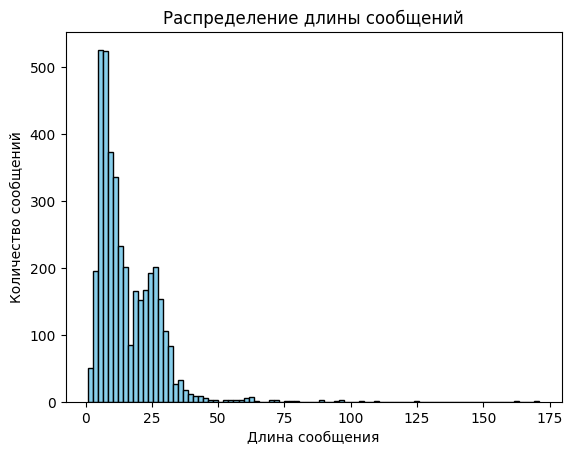

In [ ]:
# ВАШ КОД

import matplotlib.pyplot as plt

# Построение гистограммы распределения длины сообщений
len_mes = train_text.apply(lambda x: len(x.split()))
plt.hist(len_mes, bins='auto', color='skyblue', edgecolor='black')
plt.title('Распределение длины сообщений')
plt.xlabel('Длина сообщения')
plt.ylabel('Количество сообщений')
plt.show()

<h1>4. Токенизация и кодирование последовательностей</h1>

<h1>4. Токенизация <u><h2 >Какая стратегия токенизации используется BERT?</h2></u>

<p >BERT использует токенизацию WordPiece. Словарь инициализируется всеми отдельными символами языка, а затем итеративно добавляются наиболее частые/вероятные комбинации существующих слов в словаре.</p>
<br>
<u><h2>Какова максимальная длина последовательности входных данных?</h2></u>

<p>Максимальная длина входной последовательности = 512</p>Кодируйте последовательности</h1>

<b> Задание 5. Заполните пропуски </b>

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True,
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<h1>5. Преобразование списков в тензоры</h1>

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<h1 style="font-size:200%; font-family:cursive; color:navy;">6. Data Loader</h1>

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Задайте размер батча (могут быть трудности с вычислительными ресурсами при большом значении)
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

<h1>7. Архитектура модели</h1>

В данном пункте заменяются последние слои для решения задачи классификации

In [ ]:
# Заморозка всех параметров
for param in bert.parameters():
    param.requires_grad = False

<b> Задание 6. Задайте параметры выходного слоя </b>

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2) # Задайте параметры выходного слоя

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# применяем исходную модель к нашей измененной
model = BERT_Arch(bert)

# Перенесите модель на GPU
model = model.to('cuda')

In [ ]:
if torch.cuda.is_available():
    model = model.to('cuda')
    print("Модель перенесена на GPU.")
else:
    print("CUDA не доступен, модель будет использовать CPU.")

Модель перенесена на GPU.


In [ ]:
# Настройка оптимизатора
from transformers import AdamW

optimizer = AdamW(model.parameters(),lr = 1e-5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Вычисление веса класса для учета дисбаланса
class_weights = compute_class_weight(class_weight = "balanced",
                                    classes = np.unique(train_labels),
                                    y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [ ]:
# преобразование списка весов классов в тензор
weights= torch.tensor(class_weights,dtype=torch.float)

# перенос на GPU
weights = weights.to(device)

# Определение функции потерь
cross_entropy  = nn.NLLLoss(weight=weights)

# Задайте число эпох
epochs = 25

<h1 style="font-size:200%; font-family:cursive; color:navy;">8. Fine - Tune</h1>

In [ ]:
# Функция для обучения модели
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# Функция для оценки модели
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 25
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.554
Validation Loss: 0.528

 Epoch 2 / 25
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.525
Validation Loss: 0.498

 Epoch 3 / 25
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.498
Validation Loss: 0.475

 Epoch 4 / 25
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.480
Validation Loss: 0.448

 Epoch 5 / 25
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.45

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

<h1>9. Получения предсказаний</h1>
Применение модели

In [ ]:
# Получение предсказаний для тестовых данных
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       724
           1       0.71      0.90      0.79       112

    accuracy                           0.94       836
   macro avg       0.85      0.92      0.88       836
weighted avg       0.95      0.94      0.94       836



<center><h1>Полезные материалы</h1></center>

<ol>
    <li style="font-size:150%;"><a href="https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/">How to use BERT in Kaggle competitions - Reddit Thread</a></li>
    <li style="font-size:150%;"><a href="http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">A visual guide to using BERT by Jay Alammar</a></li>
    <li style="font-size:150%;"><a href="https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/">Demystifying BERT: Groundbreaking NLP Framework by Mohd Sanad Zaki Rizvi</a></li>
    <li style="font-size:150%;"><a href="https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03">BERT for Dummies step by step tutorial by Michel Kana</a></li>
</ol>